In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $k$ varying and $n$, $k_a$, $k_y$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x} = \frac{k y^n}{k_a + y^n} \\
\dot{y} = - k_y y
\end{cases}
$$
and with $n=2.8$, $k_a=4$ and $k_y=0.1$ fixed, and $k \in [1,2]$

In [2]:
# Select ODE & settings:
ode_name = 'HillODE_par_k' # help="name of the ode", type=str
ode_param = '2.8,4,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 102 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE_par_k, ode_param=[2.8, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=102, n_seed=1
Dataset shape:  (151, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.75      3.23885e+10       11         0.213208         0.203049      4.92m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     6.29          7375.66       11         0.211317         0.220074      4.71m
   2     3.69          50711.6        9         0.179862         0.180443      3.37m
   3     4.57          17874.1       19         0.111312         0.107372      3.19m
   4     6.96          12153.5        9        0.0946299        0.0994102      3.14m
   5     7.32          18648.1        9        0.0634883        0.0650134      2.61m
   6     7.66          12879.7       11        0.0631677        0.0674499      2.30m
   7     7.77          9163.95        9        0.0631306        0.0660537      2.14m
   8     8.65      1.15985e+06       11        0.0299552        0.0312191      2.05m
   9     9.11          3268.31       11        0.0299193        0.0315419      1.88m
  10     9.10          40320.2       11        0.0290708        0.0299881      1.64m
  11     9.19      1.16361e+07       11        0.0289717        0.0308809      1.49m
  12     9.67          2050.42       11        0.0264701        0

In [3]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
    x[1]*k/(x[1] + 3.9884259646106344*x[1]**(-1.763573077599074)),
    -0.10018477335405253 * x[1]
]
model = SRModel(f)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t,
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    time_vector = t[:len(pred_0_list)]

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            # Start / End
            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel("t")
            ax.set_ylabel("$x(t)$")

            ax.grid(True, alpha=0.3)

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # x(t)
            axes[0].plot(time_vector, pred_0_list[:, 0],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $x(t)$')

            axes[0].plot(time_vector, xt_true[:, 0],
                         lw=1.5, color='red', linestyle='--',
                         label='True $x(t)$')

            axes[0].scatter(time_vector[0], xt_true[0, 0],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[0].scatter(time_vector[-1], xt_true[-1, 0],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[0].set_ylabel("$x(t)$")
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=9, frameon=False)

            # y(t)
            axes[1].plot(time_vector, pred_0_list[:, 1],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $y(t)$')

            axes[1].plot(time_vector, xt_true[:, 1],
                         lw=1.5, color='red', linestyle='--',
                         label='True $y(t)$')

            axes[1].scatter(time_vector[0], xt_true[0, 1],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[1].scatter(time_vector[-1], xt_true[-1, 1],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[1].set_xlabel("t")
            axes[1].set_ylabel("$y(t)$")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=9, frameon=False)

            if title:
                fig.suptitle(title)

            plt.tight_layout()
            plt.show()

        # ---------- dim_x >= 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel("$x$")
            ax.set_ylabel("$y$")
            ax.set_zlabel("$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False)
            plt.tight_layout()
            plt.show()



from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_8358/159678848.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


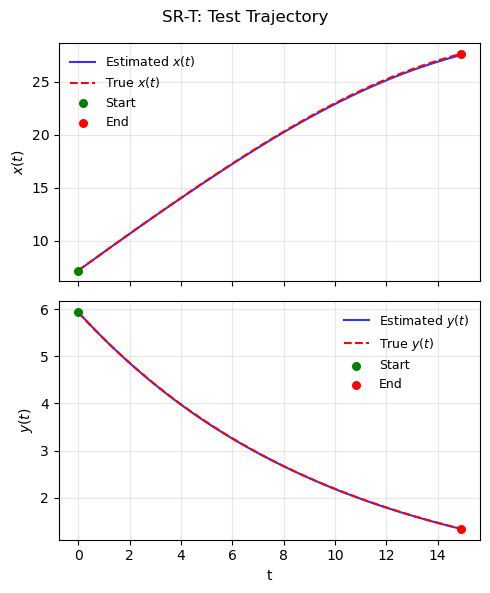

In [5]:
# n_test = 10
# rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [10., 10., 2.], [0., 0., 1.], dim_k)
# print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6., 1.8]
title = 'SR-T: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_8358/159678848.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


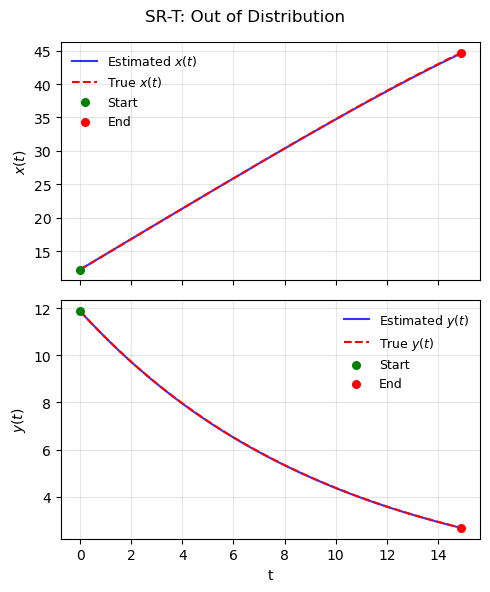

In [6]:
evaluate_sample = 1
ics = [12, 12, 2.3]
title = 'SR-T: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_8358/159678848.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


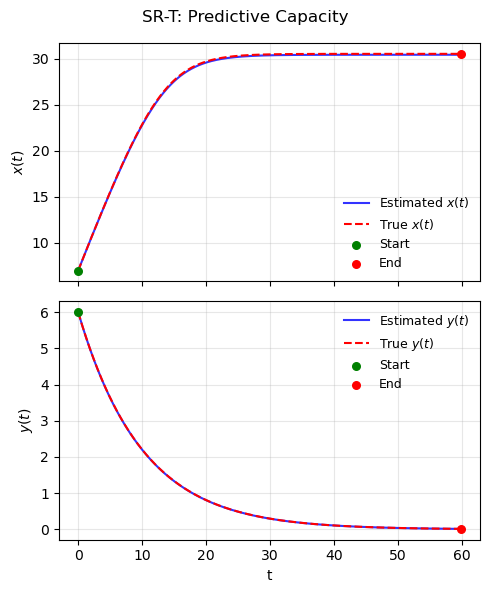

In [7]:
evaluate_sample = 1
ics = [7, 6, 1.8]
title = 'SR-T: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=60)

In [3]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE_par_k, ode_param=[2.8, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=102, n_seed=1
Dataset shape:  (301, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.75      6.82231e+27        7          15.2942          12.7855      6.34m
   1     7.38      2.28667e+15        7          14.8297          16.9657      6.97m
   2     5.33       2.9057e+16        9          9.42012          25.8246      5.06m
 
promising programs:
div(mul(X2, X1), add(X1, div(X2, pow(X1, 1.472))))
div(div(div(div(2.408, X2), div(1.660, X1)), div(div(X1, X2), mul(X1, X2))), add(2.261, X1))
div(add(X2, mul(X2, X1)), add(add(X1, X2), div(3.893, X1)))
div(mul(X2, X1), add(X1, div(X0, X0)))
div(m

In [8]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
    x[1]*k/(3.8931483381316068*x[1]**(-1.7466958166521676) + x[1]), 
    -0.09970603306146957 * x[1],
]
model = SRModel(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t,
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    time_vector = t[:len(pred_0_list)]

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            # Start / End
            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel("t")
            ax.set_ylabel("$x(t)$")

            ax.grid(True, alpha=0.3)

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # x(t)
            axes[0].plot(time_vector, pred_0_list[:, 0],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $x(t)$')

            axes[0].plot(time_vector, xt_true[:, 0],
                         lw=1.5, color='red', linestyle='--',
                         label='True $x(t)$')

            axes[0].scatter(time_vector[0], xt_true[0, 0],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[0].scatter(time_vector[-1], xt_true[-1, 0],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[0].set_ylabel("$x(t)$")
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=9, frameon=False)

            # y(t)
            axes[1].plot(time_vector, pred_0_list[:, 1],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $y(t)$')

            axes[1].plot(time_vector, xt_true[:, 1],
                         lw=1.5, color='red', linestyle='--',
                         label='True $y(t)$')

            axes[1].scatter(time_vector[0], xt_true[0, 1],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[1].scatter(time_vector[-1], xt_true[-1, 1],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[1].set_xlabel("t")
            axes[1].set_ylabel("$y(t)$")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=9, frameon=False)

            if title:
                fig.suptitle(title)

            plt.tight_layout()
            plt.show()

        # ---------- dim_x >= 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel("$x$")
            ax.set_ylabel("$y$")
            ax.set_zlabel("$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False)
            plt.tight_layout()
            plt.show()



from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_8358/1046103633.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


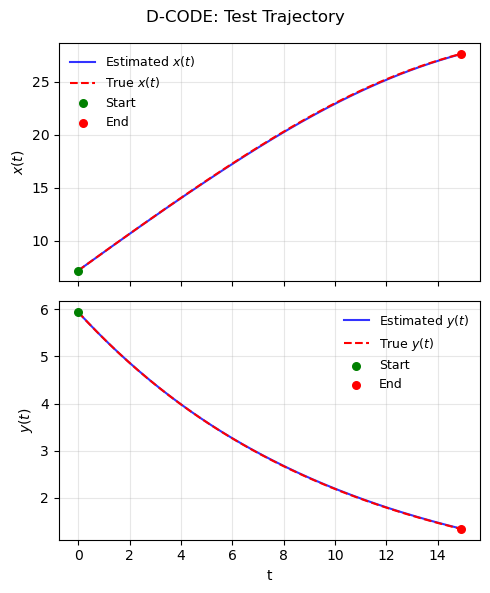

In [10]:
# n_test = 10
# rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [10., 10., 2.], [0., 0., 1.], dim_k)
# print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6., 1.8]
title = 'D-CODE: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_8358/1046103633.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


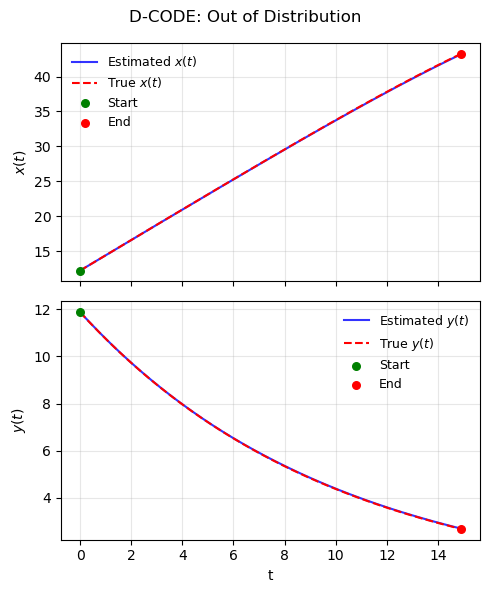

In [11]:
evaluate_sample = 1
ics = [12, 12, 2.2]
title = 'D-CODE: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_8358/1046103633.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


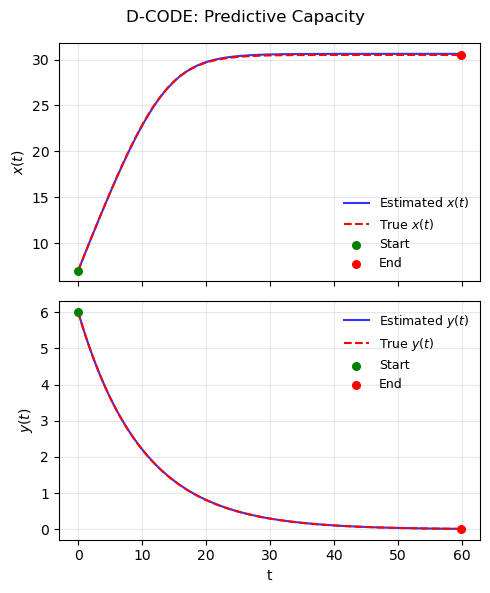

In [12]:
evaluate_sample = 1
ics = [7, 6, 1.8]
title = 'D-CODE: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=60)